In [1]:
# Eval against bead dataset
import os
import sys
import numpy as np
import pandas as pd
sys.path.insert(0,'../publication')

# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf

from util.util import _apply_img_norm, get_model_report, get_model_img_norm, show_psf_axial, apply_resizing

# model_path = '/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss/out_resnet_fov-max_aug11'
model_path = '/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss_lowsnr_data/out_resnet_fov-max_aug11'
# model_path = '/home/miguel/Projects/smlm_z/autofocus/VIT_autofocus_zeiss/out_roll_alignment'
model = tf.keras.models.load_model(model_path + '/latest_vit_model3')


from localise_exp_sample import get_model_imsize, get_model_output_scale


model_report = get_model_report(model_path)

img_norm = get_model_img_norm(model_report)
im_size = get_model_imsize(model_report)

zrange = get_model_output_scale(model_report)

2024-06-28 18:15:56.086731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 18:15:56.086752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 18:15:56.086770: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-28 18:15:56.091072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 18:15:56.625062: W tensorflow/compiler/

In [2]:
from tifffile import imread
import pandas as pd
from util.util import grid_psfs, preprocess_img_dataset, get_model_report, get_model_img_norm


noisy_stacks_dir = '/media/Backup/smlm_z_data/20240625_NUP_ifluor647/20nm_bead_Variable_SNR_stacks/combined'

stacks = os.path.join(noisy_stacks_dir, 'stacks.ome.tif')
locs = os.path.join(noisy_stacks_dir, 'locs.hdf')

stacks = imread(stacks)
locs = pd.read_hdf(locs, key='locs')

stacks.shape, locs.shape

((913, 601, 15, 15), (913, 16))

In [3]:
tmp = []
for s in stacks:
    peak = np.argmax(s.max(axis=(1,2)))
    tmp.append(s[peak-100:peak+100])
stacks = np.stack(tmp)

In [ ]:
n_frames = stacks.shape[1]
n_stacks = stacks.shape[0]
coords = locs[['x', 'y']].to_numpy()[:, np.newaxis]
coords = np.repeat(coords, n_frames, 1)
spots = np.concatenate(stacks).astype(np.float32)[:, :, :, np.newaxis]
coords = np.concatenate(coords)

print(stacks.shape, coords.shape)

In [ ]:
from localise_exp_sample import apply_coords_norm

args = {
    'coords_scaler': os.path.join(model_path, 'scaler.save')
}

coords = apply_coords_norm(coords, args)
print(coords.min(), coords.max())

In [ ]:
from util.util import preprocess_img_dataset
exp_spots = tf.data.Dataset.from_tensor_slices(spots)
exp_coords = tf.data.Dataset.from_tensor_slices(coords.astype(np.float32))

exp_X = tf.data.Dataset.zip((exp_spots, exp_coords))

fake_z = np.zeros((coords.shape[0],))
exp_z = tf.data.Dataset.from_tensor_slices(fake_z)
exp_data = tf.data.Dataset.zip((exp_X, exp_z))

def map_rgb(img_xy, z):
    img, xy = img_xy[0], img_xy[1]
    img = tf.image.grayscale_to_rgb(img)
    return (img, xy), z

exp_n_channels = model.layers[0]._batch_input_shape[-1]

if exp_data.element_spec[0][0].shape[-1] == 1 and exp_n_channels == 3:
    exp_data = exp_data.map(map_rgb)

BATCH_SIZE = 512
exp_data = exp_data.batch(BATCH_SIZE)
exp_data = preprocess_img_dataset(exp_data, im_size, img_norm)


In [ ]:
pred_z = model.predict(exp_data)
if (np.abs(pred_z) <= 1).all():
    pred_z *= zrange

In [ ]:
import matplotlib.pyplot as plt
z_preds = pred_z.reshape((n_stacks, n_frames))
i = 0

for s in z_preds:
    plt.figure(figsize=(5,5))
    plt.plot(np.arange(s.shape[0])*10, s)
    plt.show()

    i += 1

    if i > 5:
        break

In [ ]:
from tqdm import tqdm
import pandas as pd
from data.visualise import show_psf_axial

def get_snr(x):
    return x.max() / x.mean()

res = []

i = 0
for z_pred, stack in tqdm(zip(z_preds, stacks)):
    z_true = np.linspace(-1000, 1000, z_pred.shape[0], endpoint=True)
    img = stack[100]
    
    error = np.mean(abs(z_pred-z_true))
    snr = get_snr(img)
    if snr < 1.5 and i < 10:
        plt.plot(z_true, z_pred)
        plt.show()
        show_psf_axial(stack, '', 4)
        i += 1
    res.append({
        'mae': error,
        'snr': snr
    })
    
df = pd.DataFrame.from_records(res)

In [ ]:
# mae 196.86873002062876
print('mae', df['mae'].mean())

In [ ]:
import seaborn as sns
sns.scatterplot(data=df, x='snr', y='mae')
plt.show()
sns.kdeplot(data=df, x='snr', y='mae')

100%|███████████████████████████████████████| 913/913 [00:00<00:00, 1039.59it/s]


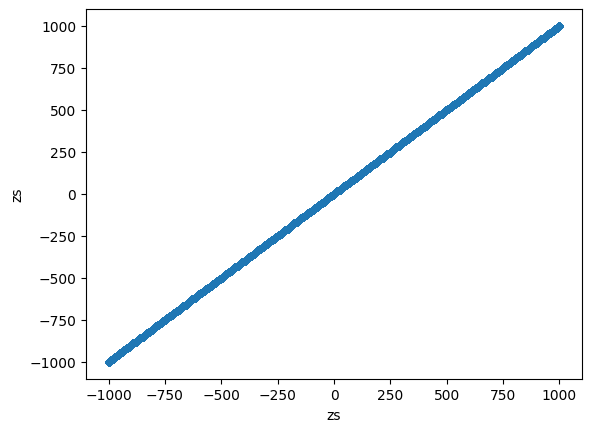

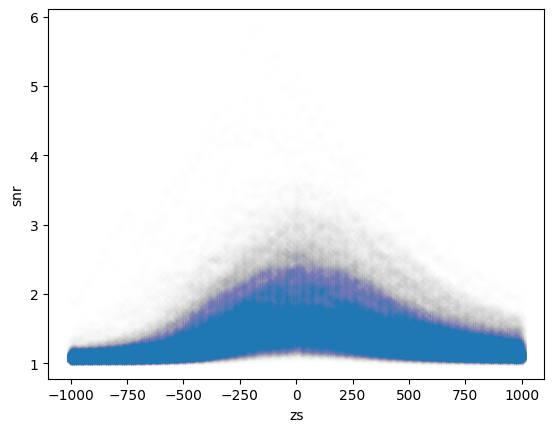

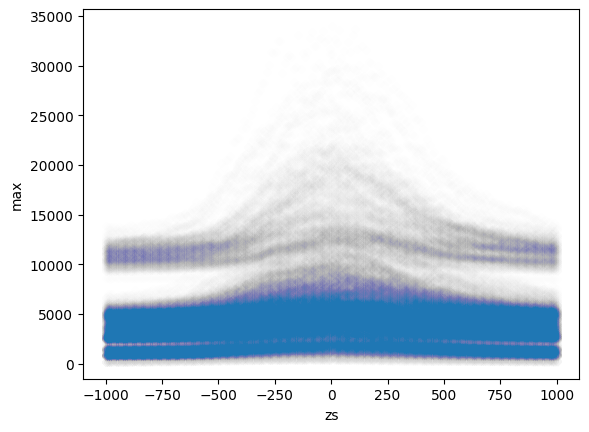

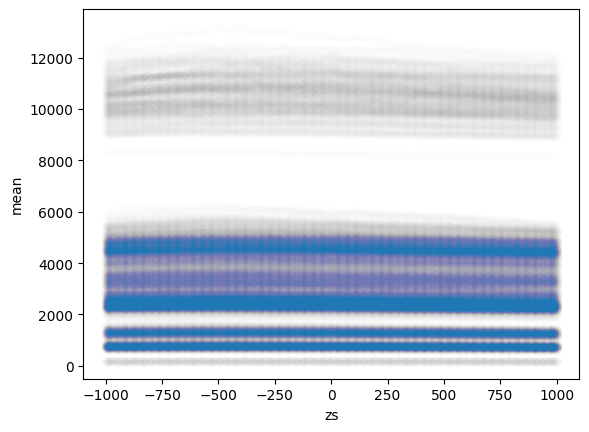

In [16]:
from tqdm import tqdm
import pandas as pd
from data.visualise import show_psf_axial
import seaborn as sns
import matplotlib.pyplot as plt

def get_snr(x):
    return x.max() / x.mean()

res = []

i = 0
zs = []
snrs = []
maxs = []
means = []
for stack in tqdm(stacks):
    z_true = np.linspace(-1000, 1000, stack.shape[0], endpoint=True)
    zs.append(z_true)
    snrs.append([get_snr(s) for s in stack])
    maxs.append(stack.max(axis=(1,2)))
    means.append(stack.mean(axis=(1,2)))

zs = np.concatenate(zs)
snrs = np.concatenate(snrs)
maxs = np.concatenate(maxs)
means = np.concatenate(means)

df2 = pd.DataFrame.from_dict({'zs': zs, 'snr': snrs, 'max': maxs, 'mean': means})

for c in list(df2):
    sns.scatterplot(data=df2, x='zs', y=c, alpha=0.005)
    plt.show()

